# Introducción

El proyecto Nuestras Caras, representa la materialización de los conceptos aprendidos en la materia Data Mining Avanzado de la Maestría en Ciencia de Datos de la Universidad Austral.

A través de este trabajo, se recorrerán diferentes etapas que fueron construyendose durante el transcurso y finalización del cursado de la materia.

Se procederá a representar gráficamente en el comienzo de cada sección, la etapa en donde se encuentre.

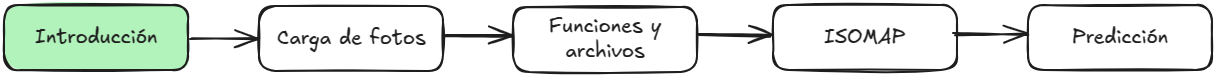

## Proceso hasta llegar a este notebook

En primer lugar, para el trabajo de "Nuestras Caras Eigenfaces" se utilizó el siguiente [notebook](https://github.com/josekeh/dma_g2/blob/main/notebooks_auxiliares/Eigenfaces___Borbiconi_Keh.ipynb)

Con él hemos recorrido:


*   Importación de las fotos
*   transformación usando cv2 para evitar sobrecargar memoria
*   reconocimiento facial y recorte nxn (finalmente 50x50)
*   PCA
*   ISOMAP y busqueda de mejores combinaciones entre componentes y vecinos

Este notebook lo utilizamos para exportar un .pkl con las fotos procesadas en dimensión nxn y poder leerlo en el próximo notebook, donde trabajamos el flujo completo para encontrar los mejores parámetros de nuestra red y realizar el entrenamiento final, pudiendo exportar la red en otro .pkl que luego es cargada en github para consumirla directamente aquí.


Pasando al siguiente [notebook](https://github.com/josekeh/dma_g2/blob/main/notebooks_auxiliares/TestEnv_NuestrasCaras_BackPropagation.ipynb), nuestro laboratorio de 12gb de RAM 😆

En él las pruebas hechas son muchas. Partiendo del notebook [BackPropagation_multiclase](https://github.com/labo-imp/dma-ros/blob/main/src/backpropagation/zBackPropagation_multiclase.ipynb) primero importamos las fotos procesadas previamente para trabajar.
Aquí el flujo es el siguiente:



1.   Separar train/test *
2.   ISOMAP **solo** con las fotos de train
3.   Transformar fotos de train y test
4.   Entrenamiento de red
5.   Cálculo de error rates con test

\* Aquí prescindimos del código óriginal para separa un dataframe y nos vamos un paso antes, para separar directamente las fotos con un algoritmo propio.

Este flujo busca encontrar los mejores hyperparámetros de la red y validar los parámetros del ISOMAP del punto anterior.

En este notebook nos encontramos muchas pruebas realizadas, en donde buscamos hacer diferentes estructuras de gridsearch para encontrar las mejores combinaciones. Luego de una estructura de loops usando **for**s, llegamos a la conclusión que debiamos reciclar los epochs porque repetíamos muchos cálculos, así que iteramos sobre el primer código ahora reciclando los mismos. Así tambien, debido a que en las primeras pruebas manuales tener la última capa oculta con 13 neuronas nos había sido positivo, lo tomamos como base, pero para explorar aún más, sacamos esta restricción. Lo que sí consideramos, al ver los resultados, es que seguiríamos probando solo redes con 2 capas ocultas, las cuales siempre daban el mejor resultado.

Si bien no fue modificado, entendemos que tambien podemos reutilizar la separación de train/test al variar el seed.

Hacer estos searchs nos llevó a muchos registros que fuimos guardando en archivos .csv, en donde calculamos las medias de test_error_rate entre los seeds probados y nos fuimos quedando con los mejores resultados.

Pero al analizar cada vez más, 24hs antes de la entrega tuvimos algo revelador, al aumentar las neuronas siempre teniamos mejor test_error... por demás de RARO.

Qué conclusión obtuvimos? Que en test, al ser las fotos tan parecidas, que el overfit lo beneficiaba, porque guardaba "lugar" para una foto casi identica. Es por esto que, a contra reloj, pusimos una prueba más, que pueda reconocer nuestros rostros, sabiendo que no están en el mismo ambiente controlado, de una forma medianamente buena.

Esto nos llevó a finalizar con una red de 2 capas, de 30 y 20 neuronas cada una con 30 componentes y 35 vecinos de isomap. Entendiendo que pudo haberse incurrido a un overfitting, se buscó una solución donde balancee un buen error_rate en test promedio con algun aciertos extra en las fotos de prueba extra.

Finalmente, el modelo fue entrenado usando este [notebook](https://github.com/josekeh/dma_g2/blob/main/notebooks_auxiliares/NuestrasCaras_BackPropagation.ipynb)




# Carga de Fotos

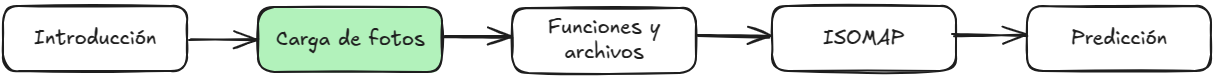

En esta sección, quien lee, debe cargar manualmente las fotos para evaluar siguiendo los pasos a continuación:

## Creación de carpeta en files
Para la carga de fotos vamos a necesitar que se carguen en algún lugar. Al correr el siguiente código, se creará una carpeta "fotos_final" en la sección de Files. Allí recomendamos simplemente arrastrar

In [ ]:
!mkdir fotos_final

In [ ]:
# # conexion al Google Drive
# from google.colab import drive
# drive.mount('/content/.drive')
# !mkdir -p "/content/.drive/My Drive/DMA/foto_final"
# !mkdir -p "/content/buckets"
# !ln -s "/content/.drive/My Drive/DMA/foto_final" /content/buckets/b2  #crea el enlace simbólico entre bucket y la carpeta foto_final

## Carga de fotos

La ruta para cargarlos es:


1.   Ir a files, opción al final de la barra lateral izquierda
2.   fotos_final y arrastrar allí las fotos
3.   Correr el código que se encuentra debajo



In [ ]:
import os
import cv2

path = '/content/fotos_final'

def importar_imagenes(path):
    lista_fotos = []
    for filename in os.listdir(path):
        full_path = os.path.join(path, filename)  # Construct the full path
        if os.path.isfile(full_path): # Check if it's a file
          try:
              img = cv2.imread(full_path, cv2.IMREAD_GRAYSCALE)
              if img is not None: # Check if the image was loaded successfully
                  lista_fotos.append(img)
              else:
                  print(f"Error: Could not read image {filename}. Skipping.")
          except Exception as e:
              print(f"Error al abrir la imagen {filename}: {e}")
        else:
          print(f"Warning: {filename} is not a file. Skipping.")

    print(f"Se encontraron {len(lista_fotos)} fotos.")
    return lista_fotos

In [ ]:
imagenes = importar_imagenes(path)

# Definición de funciones y carga de archivos necesarios

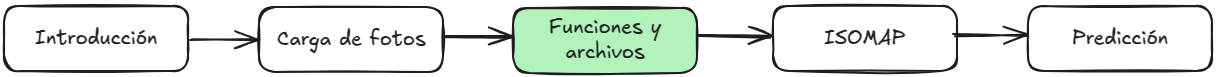

## Librerias


In [ ]:
# instalo  itables solo si no esta instalado
!pip show itables >/dev/null || pip install itables

In [ ]:
from google.colab.patches import cv2_imshow
import numpy as np
from sklearn.manifold import Isomap
from sklearn.datasets import make_swiss_roll
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pickle
import polars as pl
import math
%matplotlib inline
from IPython import display
import time
import os
from functools import reduce
from itables import init_notebook_mode
init_notebook_mode(all_interactive=True)
import cv2

## Reconocimiento facial con DNN


In [ ]:
# Descarga de Archivos
!wget -q https://raw.githubusercontent.com/opencv/opencv/master/samples/dnn/face_detector/deploy.prototxt -O deploy.prototxt
!wget -q https://github.com/opencv/opencv_3rdparty/raw/dnn_samples_face_detector_20170830/res10_300x300_ssd_iter_140000.caffemodel -O res10_300x300_ssd_iter_140000.caffemodel

In [ ]:
# DNN Face Detector
face_net = cv2.dnn.readNetFromCaffe(
    'deploy.prototxt',
    'res10_300x300_ssd_iter_140000.caffemodel'
)


# Resultados
caras = []
errores = []

# ✅ Paso 3: Iterar sobre las imágenes
# imagenes = [...]  # <- asegurate que sea una lista de [imagen_array, etiqueta]
flag = 0

for imagen in imagenes:
    flag += 1
    print(f"Procesando imagen {flag}")

    img = cv2.cvtColor(imagen, cv2.COLOR_GRAY2BGR)
    h, w = img.shape[:2]

    # Paso 1: Detectar cara
    blob = cv2.dnn.blobFromImage(img, 1.0, (300, 300), (104, 177, 123))
    face_net.setInput(blob)
    detections = face_net.forward()

    found = False
    for i in range(detections.shape[2]):
        confidence = detections[0, 0, i, 2]
        if confidence > 0.5:
            found = True
            box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
            x1, y1, x2, y2 = box.astype("int")
            x1, y1, x2, y2 = max(x1, 0), max(y1, 0), min(x2, w), min(y2, h)

            cara = img[y1:y2, x1:x2]
            if cara.size == 0:
                continue

            # Paso 3: Guardar rostro recortado (usamos FaceMesh si querés más info)
            rostro = cv2.resize(cara, (50, 50))
            caras.append(rostro)
            break

    if not found:
        print(f"No se encontró una cara en la imagen {flag}")
        errores.append(img)

# Convertir cada matriz en un vector fila 1x900
# for i in range(len(caras)):
#   caras[i] = cv2.resize(caras[i], (50, 50))
#   caras[i] = cv2.cvtColor(caras[i], cv2.COLOR_BGR2GRAY)
#   cv2_imshow(caras[i])

caras_final = caras.copy()

## ISOMAP

### Carga de isomap

Cargamos el isomap alojado en github

In [ ]:
!wget 'https://raw.githubusercontent.com/josekeh/dma_g2/main/pkl/isomap.pkl'

In [ ]:
with open("isomap.pkl", "rb") as file:
    isomap = pickle.load(file)

### Funciones

In [ ]:
def procesar_isomap(isomap, fotos):
  for i in range(len(fotos)):
    fotos[i] = cv2.resize(fotos[i], (50, 50))
    fotos[i] = cv2.cvtColor(fotos[i], cv2.COLOR_BGR2GRAY).reshape(1, 2500)
    #fotos[i] = fotos[i].reshape(1, 2500)

  fotos = np.vstack(fotos)

  output_isomap = isomap.transform(fotos)

  df_test = pl.DataFrame(output_isomap)
  df_test.columns = ['x' + str(i + 1) for i in range(df_test.shape[1])]

  return df_test

## Red neuronal

### Carga de la red neuronal

In [ ]:
!wget 'https://raw.githubusercontent.com/josekeh/dma_g2/main/pkl/red.pkl'

In [ ]:
with open("red.pkl", "rb") as file:
    red = pickle.load(file)

### Funciones

Copiamos tal cual la clase dada en los notebook de clase, entendiendo que solo necesitaríamos el predecir. Agregamos un nuevo método 'predecir_raw' para predecir sin tener valor de respuesta.

In [ ]:
# definicion de las funciones de activacion
#  y sus derivadas
#  ahora agregando las versiones VECTORIZADAS

def func_eval(fname, x):
    match fname:
        case "purelin":
            y = x
        case "logsig":
            y = 1.0 / ( 1.0 + math.exp(-x) )
        case "tansig":
            y = 2.0 / ( 1.0 + math.exp(-2.0*x) ) - 1.0
    return y

# version vectorizada de func_eval
func_eval_vec = np.vectorize(func_eval)


def deriv_eval(fname, y):  #atencion que y es la entrada y=f( x )
    match fname:
        case "purelin":
            d = 1.0
        case "logsig":
            d = y*(1.0-y)
        case "tansig":
            d = 1.0 - y*y
    return d


# version vectorizada de deriv_eval
deriv_eval_vec = np.vectorize(deriv_eval)

# definicion de la clase de multiperceptron

class multiperceptron(object):
    """Multiperceptron class"""

    # inicializacion de los pesos de todas las capas
    def _red_init(self, semilla) -> None:
        niveles = self.red['arq']['layers_qty']

        np.random.seed(semilla)
        for i in range(niveles):
           nivel = dict()
           nivel['id'] = i
           nivel['last'] = (i==(niveles-1))
           nivel['size'] = self.red["arq"]["layers_size"][i]
           nivel['func'] = self.red["arq"]["layers_func"][i]

           if( i==0 ):
              entrada_size = self.red['arq']['input_size']
           else:
              entrada_size =  self.red['arq']['layers_size'][i-1]

           salida_size =  nivel['size']

           # los pesos, inicializados random
           nivel['W'] = np.random.uniform(-0.5, 0.5, [salida_size, entrada_size])
           nivel['w0'] = np.random.uniform(-0.5, 0.5, [salida_size, 1])

           # los momentos, inicializados en CERO
           nivel['W_m'] = np.zeros([salida_size, entrada_size])
           nivel['w0_m'] = np.zeros([salida_size, 1])

           self.red['layer'].append(nivel)

    # constructor generico
    def __init__(self) -> None:
        self.data = dict()
        self.red = dict()
        self.carpeta = ""


    # inicializacion full
    def inicializar(self, df, campos, clase, hidden_layers_sizes, layers_func,
                 semilla, carpeta) -> None:

        # genero self.data
        self.data['X'] = np.array( df.select(campos))
        X_mean = self.data['X'].mean(axis=0)
        X_sd = self.data['X'].std(axis=0)
        self.data['X'] = (self.data['X'] - X_mean)/X_sd

        #  Ylabel en  numpy
        label =df.select(clase)
        self.data['Ylabel'] = np.array(label).reshape(len(label))

        # one-hot-encoding de Y
        col_originales = df.columns
        self.data['Y'] = np.array( df.to_dummies(clase).drop(col_originales, strict=False) )

        col_dummies = sorted( list( set(df.to_dummies(clase).columns) -  set(col_originales)))
        clases_originales = reduce(lambda acc, x: acc + [x[(len(clase)+1):]], col_dummies, [])

        tamanos = hidden_layers_sizes
        tamanos.append(self.data['Y'].shape[1])

        arquitectura = {
             'input_size' : self.data['X'].shape[1],
             'input_mean' : X_mean,
             'input_sd' :  X_sd,
             'output_values' : clases_originales,
             'layers_qty' : len(hidden_layers_sizes), # incluye la capa de salida, pero no la de entrada
             'layers_size' : tamanos ,
             'layers_func' : layers_func,
        }

        self.red['arq'] = arquitectura


        # inicializo  work
        self.red['work'] = dict()
        self.red['work']['epoch'] = 0
        self.red['work']['MSE'] = float('inf')
        self.red['work']['train_error_rate'] = float('inf')

        self.red['layer'] = list()
        self._red_init(semilla)

        # grabo el entorno
        self.carpeta = carpeta
        os.makedirs(self.carpeta, exist_ok=True)
        with open(self.carpeta+"/data.pkl", 'wb') as f:
            pickle.dump(self.data, f)

        with open(self.carpeta+"/red.pkl", 'wb') as f:
            pickle.dump(self.red, f)





    # Algoritmo Backpropagation
    def  entrenar(self, epoch_limit, MSE_umbral,
               learning_rate, lr_momento, save_frequency,
               retomar=True) -> None:

        # si debo retomar
        if( retomar):
            with open(self.carpeta+"/data.pkl", 'rb') as f:
              self.data = pickle.load(f)

            with open(self.carpeta+"/red.pkl", 'rb') as f:
              self.red = pickle.load(f)


        # inicializaciones del bucle principal del backpropagation
        epoch = self.red['work']['epoch']
        MSE = self.red['work']['MSE']

        # inicializacion del grafico
        grafico = perceptron_plot(X=self.data['X'], Y=self.data['Ylabel'], delay=0.1)

        # continuo mientras error cuadratico medio muy grande  y NO llegué al límite de epochs
        Xfilas = self.data['X'].shape[0]
        niveles = self.red["arq"]["layers_qty"]

        while ( MSE > MSE_umbral) and (epoch < epoch_limit) :
          epoch += 1


          # recorro siempre TODOS los registros de entrada
          for fila in range(Xfilas):
             # fila es el registro actual
             x = self.data['X'][fila:fila+1,:]
             clase = self.data['Y'][fila:fila+1,:]

             # propagar el x hacia adelante, FORWARD
             entrada = x.T  # la entrada a la red

             # etapa forward
             # recorro hacia adelante, nivel a nivel
             vsalida =  [0] *(niveles) # salida de cada nivel de la red

             for i in range(niveles):
               estimulos = self.red['layer'][i]['W'] @ entrada + self.red['layer'][i]['w0']
               vsalida[i] =  func_eval_vec(self.red['layer'][i]['func'], estimulos)
               entrada = vsalida[i]  # para la proxima vuelta


             # etapa backward
             # calculo los errores en la capa hidden y la capa output
             verror =  [0] *(niveles+1) # inicializo dummy
             verror[niveles] = clase.T - vsalida[niveles-1]

             i = niveles-1
             verror[i] = verror[i+1] * deriv_eval_vec(self.red['layer'][i]['func'], vsalida[i])

             for i in reversed(range(niveles-1)):
               verror[i] = deriv_eval_vec(self.red['layer'][i]['func'], vsalida[i])*(self.red['layer'][i+1]['W'].T @ verror[i+1])

             # ya tengo los errores que comete cada capa
             # corregir matrices de pesos, voy hacia atras
             # backpropagation
             entrada = x.T
             for i in range(niveles):
               self.red['layer'][i]['W_m'] = learning_rate *(verror[i] @ entrada.T) + lr_momento *self.red['layer'][i]['W_m']
               self.red['layer'][i]['w0_m'] = learning_rate * verror[i] + lr_momento * self.red['layer'][i]['w0_m']

               self.red['layer'][i]['W']  =  self.red['layer'][i]['W'] + self.red['layer'][i]['W_m']
               self.red['layer'][i]['w0'] =  self.red['layer'][i]['w0'] + self.red['layer'][i]['w0_m']
               entrada = vsalida[i]  # para la proxima vuelta



          # ya recalcule las matrices de pesos
          # ahora avanzo la red, feed-forward
          # para calcular el red(X) = Y
          entrada = self.data['X'].T
          for i in range(niveles):
            estimulos = self.red['layer'][i]['W'] @ entrada + self.red['layer'][i]['w0']
            salida =  func_eval_vec(self.red['layer'][i]['func'], estimulos)
            entrada = salida  # para la proxima vuelta

          # calculo el error cuadratico medio TODOS los X del dataset
          MSE= np.mean( (self.data['Y'].T - salida)**2 )

          # Grafico las rectas SOLAMENTE de la Primera Hidden Layer
          # tengo que hacer w0.T[0]  para que pase el vector limpio
          if( epoch % save_frequency == 0 ) or ( MSE <= MSE_umbral) or (epoch >= epoch_limit) :
              # grafico
              W = self.red['layer'][0]['W']
              w0 = self.red['layer'][0]['w0']
              grafico.graficarVarias(W, w0.T[0], epoch, MSE)

              # almaceno en work
              self.red['work']['epoch'] = epoch
              self.red['work']['MSE'] = MSE
              prediccion = np.argmax( salida.T, axis=1)
              # prediccion
              out = np.array(self.red["arq"]['output_values'])
              error_rate = np.mean( self.data['Ylabel'] != out[prediccion])
              self.red["work"]['train_error_rate'] = error_rate # error_rate != error cuadratico medio

              # grabo a un archivo la red neuronal  entrenada por donde esté
              #   solo la red, NO los datos
              with open(carpeta+"/red.pkl", 'wb') as f:
                 pickle.dump(self.red, f)

        return (epoch, MSE, self.red['work']['train_error_rate'] )


    # predigo a partir de modelo recien entrenado
    def  predecir(self, df_new, campos, clase) -> None:
        niveles = self.red['arq']['layers_qty']

        # etapa forward
        # recorro hacia adelante, nivel a nivel
        X_new =  np.array( df_new.select(campos))


        # estandarizo manualmente
        #  con las medias y desvios que almacene durante el entrenamiento
        X_new = (X_new - self.red['arq']['input_mean'])/self.red['arq']['input_sd']

        # grafico los datos nuevos
        Ylabel_new =df_new.select(clase)
        Ylabel_new = np.array(Ylabel_new).reshape(len(Ylabel_new))
        grafico = perceptron_plot(X=X_new, Y=Ylabel_new, delay=0.1)
        W = self.red['layer'][0]['W']
        w0 = self.red['layer'][0]['w0']
        grafico.graficarVarias(W, w0.T[0], epoch, MSE)

        # la entrada a la red,  el X que es TODO  x_new
        entrada = X_new.T  # traspongo, necesito vectores columna

        for i in range(niveles):
          estimulos = self.red['layer'][i]['W'] @ entrada + self.red['layer'][i]['w0']
          salida =  func_eval_vec(self.red['layer'][i]['func'], estimulos)
          entrada = salida  # para la proxima vuelta

        # me quedo con la neurona de la ultima capa que se activio con mayor intensidad
        pred_idx = np.argmax( salida.T, axis=1)
        pred_raw = np.max( salida.T, axis=1)

        # calculo error_rate
        out = np.array(self.red['arq']['output_values'])
        error_rate = np.mean( np.array(df_new.select("y") != out[pred_idx]))

        return (out[pred_idx], pred_raw, error_rate)


    # cargo un modelo ya entrenado, grabado en carpeta
    def cargar_modelo(self, carpeta) -> None:
        self.carpeta = carpeta

        with open(self.carpeta+"/red.pkl", 'rb') as f:
          self.red = pickle.load(f)

        return (self.red['work']['epoch'],
                self.red['work']['MSE'],
                self.red['work']['train_error_rate'] )

    # predigo a partir de modelo recien entrenado
    def  predecir_raw(self, df_new, campos) -> None:
        niveles = self.red['arq']['layers_qty']

        # etapa forward
        # recorro hacia adelante, nivel a nivel
        X_new =  np.array( df_new.select(campos))


        # estandarizo manualmente
        #  con las medias y desvios que almacene durante el entrenamiento
        X_new = (X_new - self.red['arq']['input_mean'])/self.red['arq']['input_sd']

        # la entrada a la red,  el X que es TODO  x_new
        entrada = X_new.T  # traspongo, necesito vectores columna

        for i in range(niveles):
          estimulos = self.red['layer'][i]['W'] @ entrada + self.red['layer'][i]['w0']
          salida =  func_eval_vec(self.red['layer'][i]['func'], estimulos)
          entrada = salida  # para la proxima vuelta

        # me quedo con la neurona de la ultima capa que se activio con mayor intensidad
        pred_idx = np.argmax( salida.T, axis=1)
        pred_raw = np.max( salida.T, axis=1)

        # calculo error_rate
        out = np.array(self.red['arq']['output_values'])

        return (out[pred_idx], pred_raw)

# Procesar ISOMAP

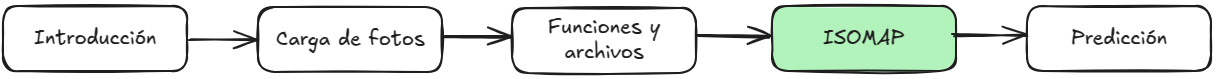

In [ ]:
df_test = procesar_isomap(isomap, caras)

# Predicción

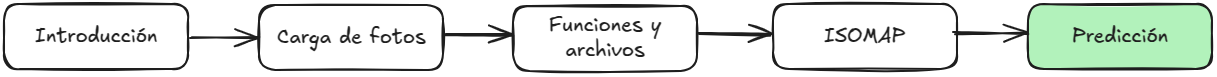

In [ ]:
# Carga de la red
mp = multiperceptron()

In [ ]:
(epoch, MSE, train_error_rate) = mp.cargar_modelo('/content') #usamos content porque la cargamos arriba

In [ ]:
x_campos = df_test.columns

In [ ]:
(y_hat,y_raw) = mp.predecir_raw(df_new=df_test, campos=x_campos)

In [ ]:
tb_salida_new = pl.DataFrame( {"pred":y_hat, "y_raw":y_raw })
tb_salida_new

In [ ]:
for i in range(len(caras_final)):
  print(y_hat[i],round(y_raw[i]*100,2),"% :")
  cv2_imshow(caras_final[i])
  print("----------")


Por qué no buscamos "Intrusos'? La realidad es que con las ultimas revelaciones de la estructura de la red teniamos casos donde se predecía bien pero con valores de respuesta bajo. El detectar el intruso por un umbral, en este caso nos puede llevar a un falso negativo, lo cual, al no poder depurar aún más el código, creemos que es preferible evitarlo y a lo sumo, asumir el riesgo de un falso positivo.